# Ideias:
- Verificar o primeiro colocado com mais e com menos pontos (e a porcentagem de pontos ganhos deles)
- Verificar o décimo sexto colocado com mais e com menos pontos
- Dividir os times pelas regiões e identificar a porcentagem da média de vezes que os times da região apareceram
- Plotar gráfico, mapa do Brasil com os estados de times que já jogaram o campeonato BR dentro do período estudado
- Ver a colocação do time do artilheiro de cada ano e a porcentagem de gols do time foi do artilheiro

### Hipótese: Gols sofridos influenciam muito mais, tornando a defesa 'mais importante' do que o ataque.

In [1]:
import json
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Criação da função para pegar os dados, parâmetro default para a classificação da série A

In [2]:
def get_data_from_division(series='a'):
    data = []
    for year in range(2012, 2024):
        url = f'http://localhost:9080/crawl.json?spider_name=cbf_spider&url=https://www.cbf.com.br/futebol-brasileiro/competicoes/campeonato-brasileiro-serie-{series}/{year}'
        response = requests.get(url)
        data.extend(response.json()['items'])
    return data

### Captura dos dados dos anos 2012 a 2023 das classificações da série A e B do Brasileirão 

In [3]:
serie_a = get_data_from_division()
serie_b = get_data_from_division(series='b')
df_a = pd.DataFrame(serie_a)
df_b = pd.DataFrame(serie_b)
df_b

,year,position,team,points,games,wins,draws,losses,goals_for,goals_against,goal_difference,percentage,top_player_scorer
0,2012,1,Goiás - GO,78,38,23,9,6,75,37,38,68,"{'team': 'Criciuma - SC', 'name': 'ZE CARLOS',..."
1,2012,2,Criciuma - SC,73,38,22,7,9,78,57,21,64,"{'team': 'Criciuma - SC', 'name': 'ZE CARLOS',..."
2,2012,3,Atlético - PR,71,38,21,8,9,65,37,28,62,"{'team': 'Criciuma - SC', 'name': 'ZE CARLOS',..."
3,2012,4,Vitória - BA,71,38,21,8,9,59,43,16,62,"{'team': 'Criciuma - SC', 'name': 'ZE CARLOS',..."
4,2012,5,São Caetano - SP,71,38,20,11,7,58,38,20,62,"{'team': 'Criciuma - SC', 'name': 'ZE CARLOS',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2023,16,Ponte Preta - SP,34,31,7,13,11,20,30,-10,36,"{'team': 'Atlético - GO', 'name': 'Gustavo Cou..."
236,2023,17,Chapecoense - SC,33,32,7,12,13,29,35,-6,34,"{'team': 'Atlético - GO', 'name': 'Gustavo Cou..."
237,2023,18,Tombense - MG,28,32,6,10,16,31,43,-12,29,"{'team': 'Atlético - GO', 'name': 'Gustavo Cou..."
238,2023,19,Londrina - PR,24,31,6,6,19,25,49,-24,25,"{'team': 'Atlético - GO', 'name': 'Gustavo Cou..."


Considerando que o objetivo é identificar o melhor e o pior time primeiro, e também o décimo sétimo, optei por separar as funções. Mas abaixo está um exemplo de uma função para evitar repetição de código e que englobe tudo que quero, contém parâmetros: o primeiro representa o dataframe desejado (df_a ou df_b), o segundo é a posição desejada e o terceiro é um valor booleano indicando se devemos buscar o melhor ou o pior nessa posição. Se o parâmetro for True, o código identificará o melhor; se for False, identificará o pior. Por exemplo, ao inserir (df_b, 5, False), o código irá identificar o quinto pior colocado da Série B.

In [4]:
def get_best_first_position(df):
    first_place = df['position'] ==  '1'
    df_best_first_place = df.loc[first_place].sort_values(by=['percentage'], ascending=False)
    best_first = df_best_first_place.head(1).iloc[0]['team'].split('-')[0].strip()
    return print(f'O melhor campeão foi o {best_first} em {df_best_first_place.head(1).iloc[0]["year"]}.\nEles fizeram  {df_best_first_place.head(1).iloc[0]["points"]} pontos - {df_best_first_place.head(1).iloc[0]["percentage"]}% dos pontos disputados')

def get_worst_first_position(df):
    first_place = df['position'] ==  '1'
    df_worst_first_colocado = df.loc[first_place].sort_values(by=['percentage'], ascending=False)
    worst_first = df_worst_first_colocado.tail(1).iloc[0]['team'].split('-')[0].strip()
    return print(f'O pior campeão foi o {worst_first} em {df_worst_first_colocado.tail(1).iloc[-1]["year"]}.\nEles fizeram {df_worst_first_colocado.tail(1).iloc[0]["points"]} points - {df_worst_first_colocado.tail(1).iloc[-1]["percentage"]}% dos pontos disputados')

def get_best_seventeenth_position(df):
    seventeenth_place = df['position'] ==  '17'
    df_best_seventeenth_place = df.loc[seventeenth_place].sort_values(by=['percentage'], ascending=False)
    best_seventeenth = df_best_seventeenth_place.head(1).iloc[0]['team'].split('-')[0].strip()
    return print(f'O melhor décimo sétimo colocado foi os {best_seventeenth} em {df_best_seventeenth_place.head(1).iloc[0]["year"]}.\nEles fizeram  {df_best_seventeenth_place.head(1).iloc[0]["points"]} points - {df_best_seventeenth_place.head(1).iloc[0]["percentage"]}% dos pontos disputados')

def get_worst_seventeenth_position(df):
    seventeenth_place = df['position'] ==  '17'
    df_worst_seventeenth_colocado = df.loc[seventeenth_place].sort_values(by=['percentage'], ascending=False)
    worst_seventeenth = df_worst_seventeenth_colocado.tail(1).iloc[0]['team'].split('-')[0].strip()
    return print(f'O pior décimo sétimo colocado foi o {worst_seventeenth} em {df_worst_seventeenth_colocado.tail(1).iloc[-1]["year"]}.\nEles fizeram  {df_worst_seventeenth_colocado.tail(1).iloc[0]["points"]} points - {df_worst_seventeenth_colocado.tail(2).iloc[-1]["percentage"]}% dos pontos disputados')

In [5]:
print('Série A\n')
get_best_first_position(df_a)
print('----')
get_worst_first_position(df_a)
print('----')
get_best_seventeenth_position(df_a)
print('----')
get_worst_seventeenth_position(df_a)

print('\nSérie B\n')
get_best_first_position(df_b)
print('----')
get_worst_first_position(df_b)
print('----')
get_best_seventeenth_position(df_b)
print('----')
get_worst_seventeenth_position(df_b)

Série A

O melhor campeão foi o Flamengo em 2019.
Eles fizeram  90 pontos - 78% dos pontos disputados
----
O pior campeão foi o Flamengo em 2020.
Eles fizeram 71 points - 62% dos pontos disputados
----
O melhor décimo sétimo colocado foi os Portuguesa em 2013.
Eles fizeram  44 points - 38% dos pontos disputados
----
O pior décimo sétimo colocado foi o Cruzeiro em 2019.
Eles fizeram  36 points - 31% dos pontos disputados

Série B

O melhor campeão foi o Palmeiras em 2013.
Eles fizeram  79 pontos - 69% dos pontos disputados
----
O pior campeão foi o Botafogo em 2021.
Eles fizeram 70 points - 61% dos pontos disputados
----
O melhor décimo sétimo colocado foi os Luverdense em 2017.
Eles fizeram  44 points - 38% dos pontos disputados
----
O pior décimo sétimo colocado foi o Chapecoense em 2023.
Eles fizeram  33 points - 34% dos pontos disputados


In [6]:
def get_position_stats(df=df_a, position=1, best=True):
    place = df['position'] ==  str(position)
    df_place = df.loc[place].sort_values(by=['percentage'], ascending=False)
    
    if best:
        team_info = df_place.head(1).iloc[0]
        print(f'O melhor time na posição {position} foi o{team_info["team"].split("-")[0].strip()} em {team_info["year"]}.\nEles fizeram {team_info["points"]} pontos - {team_info["percentage"]}% dos pontos disputados')
    else:
        team_info = df_place.tail(1).iloc[0]
        print(f'O pior time na posição {position} foi o {team_info["team"].split("-")[0].strip()} em {team_info["year"]}.\nEles fizeram {team_info["points"]} pontos - {team_info["percentage"]}% dos pontos disputados')

get_position_stats(df_b, 5, False)

O pior time na posição 5 foi o Sampaio Corrêa em 2022.
Eles fizeram 58 pontos - 50% dos pontos disputados


A média de porcentagem de porcentagem de pontos ganhos do campeão de 2012 a 2022:

In [54]:
first_place = df_a['position'] ==  '1'
df_best_first_place = df_a.loc[first_place].sort_values(by=['year'], ascending=False)
best_first = df_best_first_place[1:].head(20)
media = sum(best_first['percentage'].astype(int)) / best_first.shape[0]
print(f'A média foi de {media:.2f}%')

A média foi de 69.18%


In [99]:
print(f'Neste momento (16/11/2023), após 26 rodadas, o Botafogo possui {df_best_first_place["percentage"].head(1).iloc[0]}% de aproveitamento, o que o coloca acima da média de pontos dos times campeões. Se a equipe mantiver esse desempenho, é provável que conquiste o título, a menos que algum dos outros times tenha um desempenho final com uma média de pontos muito superior à média de um time campeão.')

Neste momento (16/11/2023), após 26 rodadas, o Botafogo possui 70% de aproveitamento, o que o coloca acima da média de pontos dos times campeões. Se a equipe mantiver esse desempenho, é provável que conquiste o título, a menos que algum dos outros times tenha um desempenho final com uma média de pontos muito superior à média de um time campeão.



# Porcentagem de times por região do Brasil

In [7]:
def team_per_region(df):
    mask_centro_oeste = df['team'].str[-2:].isin(['GO', 'MT', 'MS', 'DF'])
    mask_centro_oeste = df.loc[mask_centro_oeste]
    porcentagem_centro_oeste = (mask_centro_oeste.shape[0]/12)/20

    mask_ne = df['team'].str[-2:].isin(['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'])
    ne_teams = df.loc[mask_ne]
    porcentagem_ne = (ne_teams.shape[0]/12)/20

    mask_rs = df['team'].str[-2:].isin(['RS', 'SC', 'PR'])
    sul_teams = df.loc[mask_rs]
    porcentagem_sul = (sul_teams.shape[0]/12)/20

    mask_sudeste = df['team'].str[-2:].isin(['SP', 'RJ', 'MG', 'ES'])
    sudeste_teams = df.loc[mask_sudeste]
    porcentagem_sudeste = (sudeste_teams.shape[0]/12)/20

    df_regioes = pd.DataFrame({
        "regiao": ['N', 'CO', 'NE', 'SE', 'RS'],
        "porcentagem": [0, porcentagem_centro_oeste, porcentagem_ne, porcentagem_sudeste, porcentagem_sul]
    })
    return df_regioes

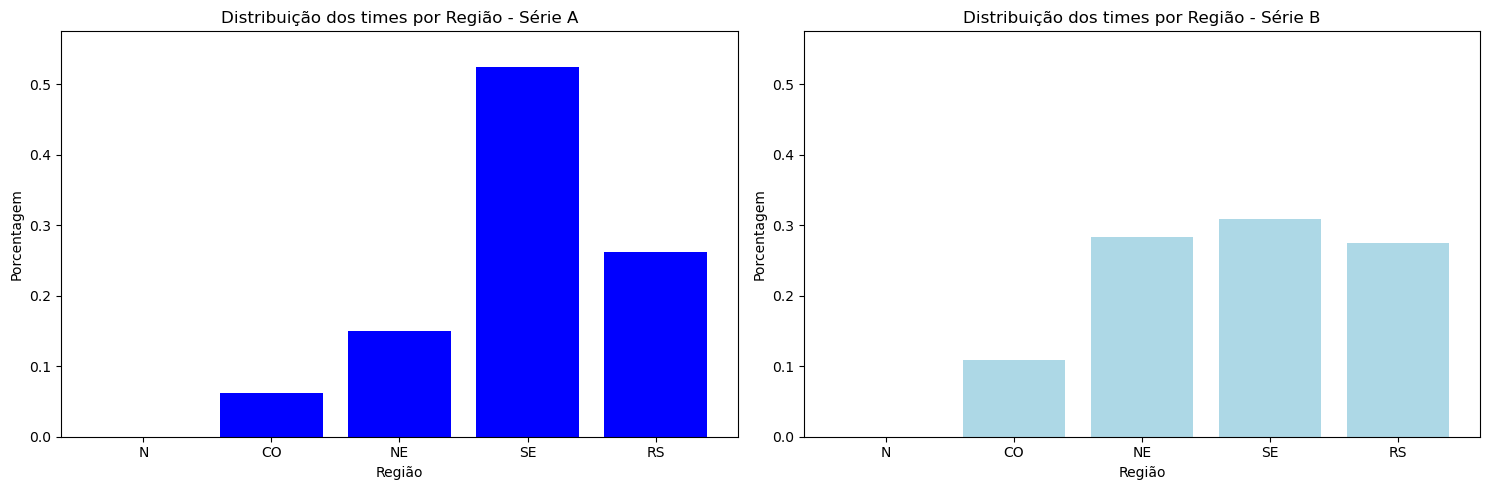

In [8]:
df1 = team_per_region(df_a)
df2 = team_per_region(df_b)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ymin = min(df1['porcentagem'].min(), df2['porcentagem'].min())
ymax = max(df1['porcentagem'].max(), df2['porcentagem'].max()) + 0.05


axs[0].bar(df1['regiao'], df1['porcentagem'], color='blue')
axs[0].set_title('Distribuição dos times por Região - Série A')
axs[0].set_xlabel('Região')
axs[0].set_ylabel('Porcentagem')
axs[0].set_ylim([ymin, ymax])  


axs[1].bar(df2['regiao'], df2['porcentagem'], color='lightblue')
axs[1].set_title('Distribuição dos times por Região - Série B')
axs[1].set_xlabel('Região')
axs[1].set_ylabel('Porcentagem')
axs[1].set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()


In [9]:
def teams_per_state(df):
    mask_estados = df['team'].str[-2:]
    df['estados'] = mask_estados
    quantidade_estados = df[['year', 'estados']].groupby(by=['estados']).count()
    quantidade_estados = quantidade_estados.rename(columns={'year': 'quantidade'})
    quantidade_estados.reset_index(inplace=True)
    quantidade_estados.rename(columns={'index': 'estados'}, inplace=True)
    quantidade_estados.rename(columns = {'estados': 'SIGLA'}, inplace=True)
    return quantidade_estados

In [10]:
mapa_brasil = gpd.read_file('./src/BR_UF_2021.shp')

/tmp/ipykernel_12979/301640130.py:7: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  merged.fillna(0, inplace=True)
/home/rodrigo/.local/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/tmp/ipykernel_12979/301640130.py:7: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  merged.fillna(0, inplace=True)
/home/rodrigo/.local/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureW

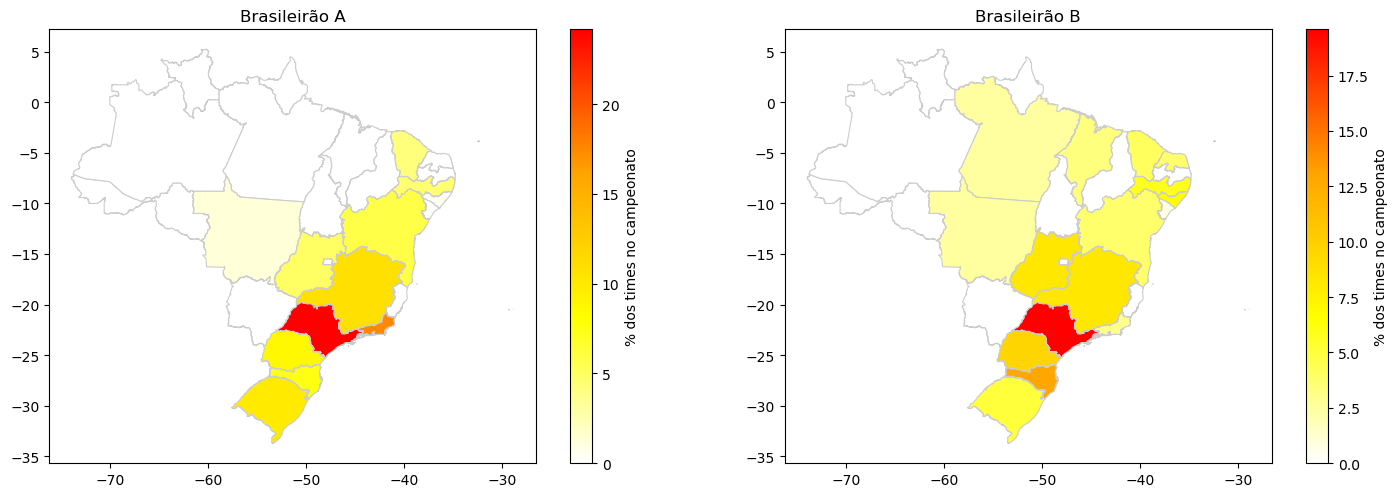

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
colors = ["white", "yellow", "orange", "red"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

def prepare_and_plot(df, ax, title):
    merged = mapa_brasil.merge(teams_per_state(df), on='SIGLA', how='outer')
    merged.fillna(0, inplace=True)
    merged['porcentagem'] = (merged['quantidade']/240)*100

    merged.plot(column='porcentagem', 
                cmap=cmap, 
                linewidth=0.8, 
                ax=ax, 
                edgecolor='0.8',
                legend=True,
                legend_kwds={'label': "% dos times no campeonato",
                             'orientation': "vertical"})
    ax.set_title(title)


prepare_and_plot(df_a, axs[0], 'Brasileirão A')
prepare_and_plot(df_b, axs[1], 'Brasileirão B')

plt.tight_layout()
plt.show()

In [12]:
df_a_copy = df_a.copy()
df_b_copy = df_b.copy()

In [13]:
def assign_goals(row):
    if row['team'] == row['top_player_scorer']['team']:
        return int(row['top_player_scorer']['goals'])
    else:
        return 0

def show_top_scorer(df):
    df['top_scorer_goals'] = df.apply(assign_goals, axis=1)
    df['goals_for'] = df['goals_for'].astype(int)
    df['top_scorer_rate'] = df['top_scorer_goals'] / df['goals_for']
    df_top_scorers = df[df['top_scorer_goals'] != 0]
    df = df_top_scorers.assign(
        top_scorer_name = df_top_scorers['top_player_scorer'].apply(lambda x: x['name']),
        top_scorer_goals = df_top_scorers['top_player_scorer'].apply(lambda x: x['goals']))[
            ['year', 'team', 'position', 'goals_for', 'points', 'top_scorer_name', 'top_scorer_goals', 'top_scorer_rate']
            ].sort_values(by=['top_scorer_goals'], ascending=False)
    return df



### Mostrar o artilheiro, o time, que colocação o time terminou e a porcentagem dos gols do artilheiro em relação ao total de gols do time de cada edição do campeonato de ambas as séries

In [14]:
# Série A

show_top_scorer(df_a_copy)


,year,team,position,goals_for,points,top_scorer_name,top_scorer_goals,top_scorer_rate
202,2022,Fluminense - RJ,3,63,70,German Cano,27,0.428571
140,2019,Flamengo - RJ,1,86,90,Gabriel Barbosa,25,0.290698
22,2013,Atlético Paranaense - PR,3,65,64,Ederson,21,0.323077
0,2012,Fluminense - RJ,1,61,77,FRED,20,0.327869
66,2015,Santos - SP,7,59,58,Ricardo Oliveira,20,0.338983
180,2021,Atlético Mineiro - MG,1,67,84,Hulk,19,0.283582
45,2014,Fluminense - RJ,6,61,61,Fred,18,0.295082
100,2017,Corinthians - SP,1,50,72,Jo,18,0.360000
129,2018,Santos - SP,10,46,50,Gabriel B.,18,0.391304
169,2020,Red Bull Bragantino - SP,10,50,53,Claudinho,18,0.360000


O melhor artilheiro durante o período analisado foi Cano, que marcou 27 gols na edição de 2022. Além disso, ele contribuiu com 42.8% de todos os gols do Fluminense no campeonato, uma porcentagem notavelmente alta e evidenciando a dependência que o Fluminense tinha dos gols de Cano. Também é importante notar que Gabriel Barbosa alcançou essa conquista em dois anos, primeiro em 2018 com o Santos e depois em 2019 com o Flamengo. Tanto ele quanto Claudinho conseguiram ser artilheiros, mesmo com seus times terminando na décima colocação.

In [15]:
# Série B

show_top_scorer(df_b_copy)

,year,team,position,goals_for,points,top_scorer_name,top_scorer_goals,top_scorer_rate
21,2013,Chapecoense - SC,2,60,72,Bruno,31,0.516667
1,2012,Criciuma - SC,2,78,73,ZE CARLOS,27,0.346154
70,2015,Crb - AL,11,47,54,Ze Carlos,19,0.404255
204,2022,Sampaio Corrêa - MA,5,48,58,Poveda,19,0.395833
47,2014,Ceará - CE,8,58,57,Magno,18,0.310345
127,2018,Londrina - PR,8,45,55,Dagoberto,17,0.377778
141,2019,Sport - PE,2,49,68,Guilherme Augusto,17,0.346939
165,2020,Sampaio Correa - MA,6,50,57,Caio,17,0.340000
192,2021,Brusque - SC,13,44,48,Eduardo,17,0.386364
105,2017,Oeste - SP,6,43,59,Mazinho,16,0.372093


O principal artilheiro durante o período analisado foi Bruno, da Chapecoense, que marcou 31 gols, correspondendo a 51,66% dos gols marcados pela equipe no Campeonato Brasileiro de 2013. Em contraste com a Série A, na Série B, observa-se uma grande discrepância na diferença de gols entre os dois principais artilheiros em comparação com os demais. Por exemplo, o segundo melhor artilheiro marcou oito gols a mais do que o terceiro colocado. Além disso, o já mencionado Bruno marcou mais do que o dobro de gols do artilheiro de 2016, Bil, do Ceará.

# <font color='blue'>Machine Learning para identificar se no Brasileirão da série A marcar mais gols ou sofrer menos tem um impacto maior na colocação final da equipe.</font>

In [16]:
# RandomForestRegressor - Seed 42
SEED = 42

X = df_a[['goals_for', 'goals_against']]
y = df_a['position']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

for feature, importance in zip(X.columns, importances):
    print(f"The importance of {feature} is {importance}")

The importance of goals_for is 0.5087319176501518
The importance of goals_against is 0.4912680823498483


/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [17]:
# Using Decision Tree Regressor - Seed 42
SEED = 42

X = df_a[['goals_for', 'goals_against']]
y = df_a['position']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

for feature, importance in zip(X.columns, importances):
    print(f"The importance of {feature} is {importance}")


The importance of goals_for is 0.5882517282972203
The importance of goals_against is 0.4117482717027797


/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [18]:
from sklearn.model_selection import cross_val_score

# Assuming model is your Decision Tree or Random Forest model
scores = cross_val_score(model, X, y, cv=5)  # cv=5 means 5-fold cross-validation

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")


Cross-validation scores: [0.74472705 0.63894185 0.74109071 0.65689546 0.74798387]
Average cross-validation score: 0.7059277872454637


/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarn

In [19]:
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Cross-validation scores: [0.74472705 0.63894185 0.74109071 0.65689546 0.74798387]
Average cross-validation score: 0.7059277872454637


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
}

# GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5)


grid_search.fit(X, y)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarn

/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarn

/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarn

Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score: 0.7381222171685928


/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/rodrigo/Desktop/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarn

print acima:
Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score: 0.7368149231423617

73.68% é um valor aceitável.


### <font color='red'>Não validamos a hipótese de que os gols marcados são mais importantes do que os sofridos. A amostragem é limitada e depende dos dados de treinamento e teste, mas com o seed que utilizamos, constatamos que na Série A, a importância dos gols feitos e sofridos para a colocação no campeonato é quase 50-50%. Por outro lado, na Série B, com o seed 42, os gols marcados são mais relevantes, representando aproximadamente 59%</font>